In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional, List
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    confusion_matrix, classification_report
)

# Gradient Boosting libraries
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Hyperparameter optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Library availability flags (since imports succeeded, all are available)
LIGHTGBM_AVAILABLE = True
XGBOOST_AVAILABLE = True
CATBOOST_AVAILABLE = True
OPTUNA_AVAILABLE = True

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Загрузка данных

In [72]:
# Paths to data files
DATA_DIR = Path('dataset')
TRAIN_PATH = DATA_DIR / 'train_c.csv'
TEST_PATH = DATA_DIR / 'test_c.csv'

# Load data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
train_df.head()

Train shape: (11017, 35)
Test shape: (5000, 35)

Train columns: ['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'EmploymentStatus', 'EducationLevel', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']

First few rows:


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,0.151985,2.0,1.0,0.168542,0.0,Education,0.0,23.0,5.0,2539.0,247.0,50072.0,15005.0,5569.083333,0.908289,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,0.175693,3.0,0.0,0.141553,0.0,Home,0.0,27.0,11.0,844.0,694.0,91878.0,64877.0,14345.583333,0.797339,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,0.444605,3.0,0.0,0.030987,1.0,Education,0.0,21.0,12.0,12756.0,651.0,292300.0,13918.0,25000.000000,0.915945,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,0.188452,7.0,0.0,0.379843,0.0,Debt Consolidation,0.0,27.0,21.0,1524.0,529.0,13070.0,3846.0,2890.250000,0.876416,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,0.273431,3.0,1.0,0.068659,0.0,Debt Consolidation,0.0,35.0,9.0,1973.0,128.0,33357.0,351603.0,25000.000000,0.888689,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


1. Exploratory Data Analysis (EDA) - 1 балл

In [73]:
missing = train_df.isnull().sum()
missing_pct = 100 * missing / len(train_df)
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False))

                            Missing  Percentage
TotalAssets                    1031    9.358265
CreditScore                    1031    9.358265
LoanAmount                     1031    9.358265
BaseInterestRate               1031    9.358265
NetWorth                       1031    9.358265
MonthlyDebtPayments            1031    9.358265
CheckingAccountBalance         1031    9.358265
LoanPurpose                    1031    9.358265
BankruptcyHistory              1031    9.358265
JobTenure                       530    4.810747
TotalLiabilities                530    4.810747
MonthlyIncome                   530    4.810747
UtilityBillsPaymentHistory      530    4.810747
ApplicationDate                 530    4.810747
EmploymentStatus                530    4.810747
EducationLevel                  530    4.810747
InterestRate                    530    4.810747
MonthlyLoanPayment              530    4.810747
TotalDebtToIncomeRatio          530    4.810747
Experience                      530    4

LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64

Class distribution:
LoanApproved
1.0    0.511776
0.0    0.488224
Name: proportion, dtype: float64


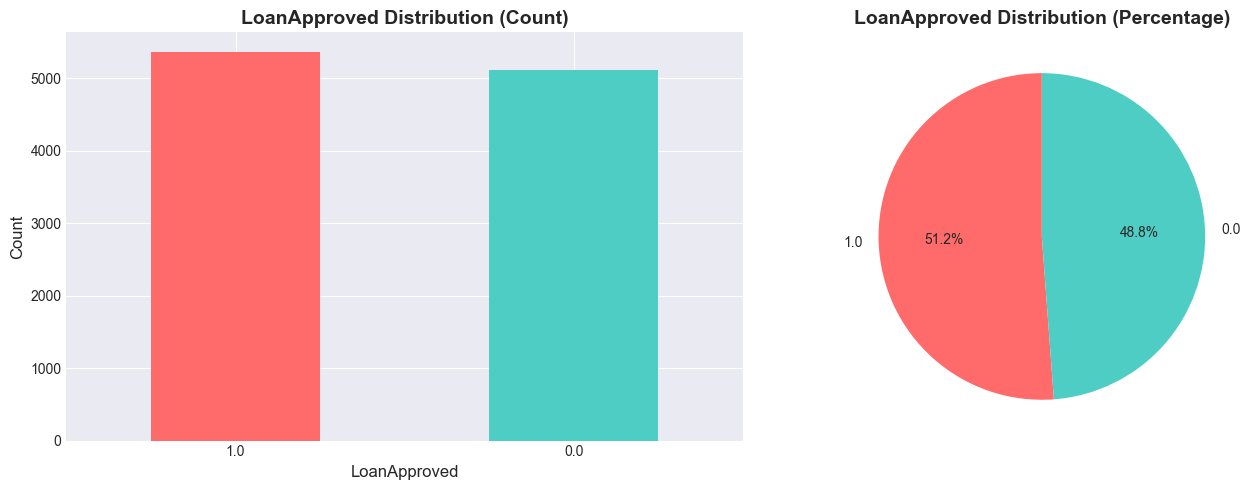


Class imbalance ratio (class 0 / class 1): 0.95


In [74]:
print(train_df['LoanApproved'].value_counts())
print(f"\nClass distribution:")
print(train_df['LoanApproved'].value_counts(normalize=True))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_df['LoanApproved'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('LoanApproved Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('LoanApproved', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)

train_df['LoanApproved'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                             colors=['#FF6B6B', '#4ECDC4'], startangle=90)
axes[1].set_title('LoanApproved Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

class_ratio = train_df['LoanApproved'].value_counts()[0] / train_df['LoanApproved'].value_counts()[1]
print(f"\nClass imbalance ratio (class 0 / class 1): {class_ratio:.2f}")

In [75]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'LoanApproved' in numeric_cols:
    numeric_cols.remove('LoanApproved')
if 'ID' in numeric_cols:
    numeric_cols.remove('ID')

categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

Numeric columns (28): ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio']

Categorical columns (6): ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


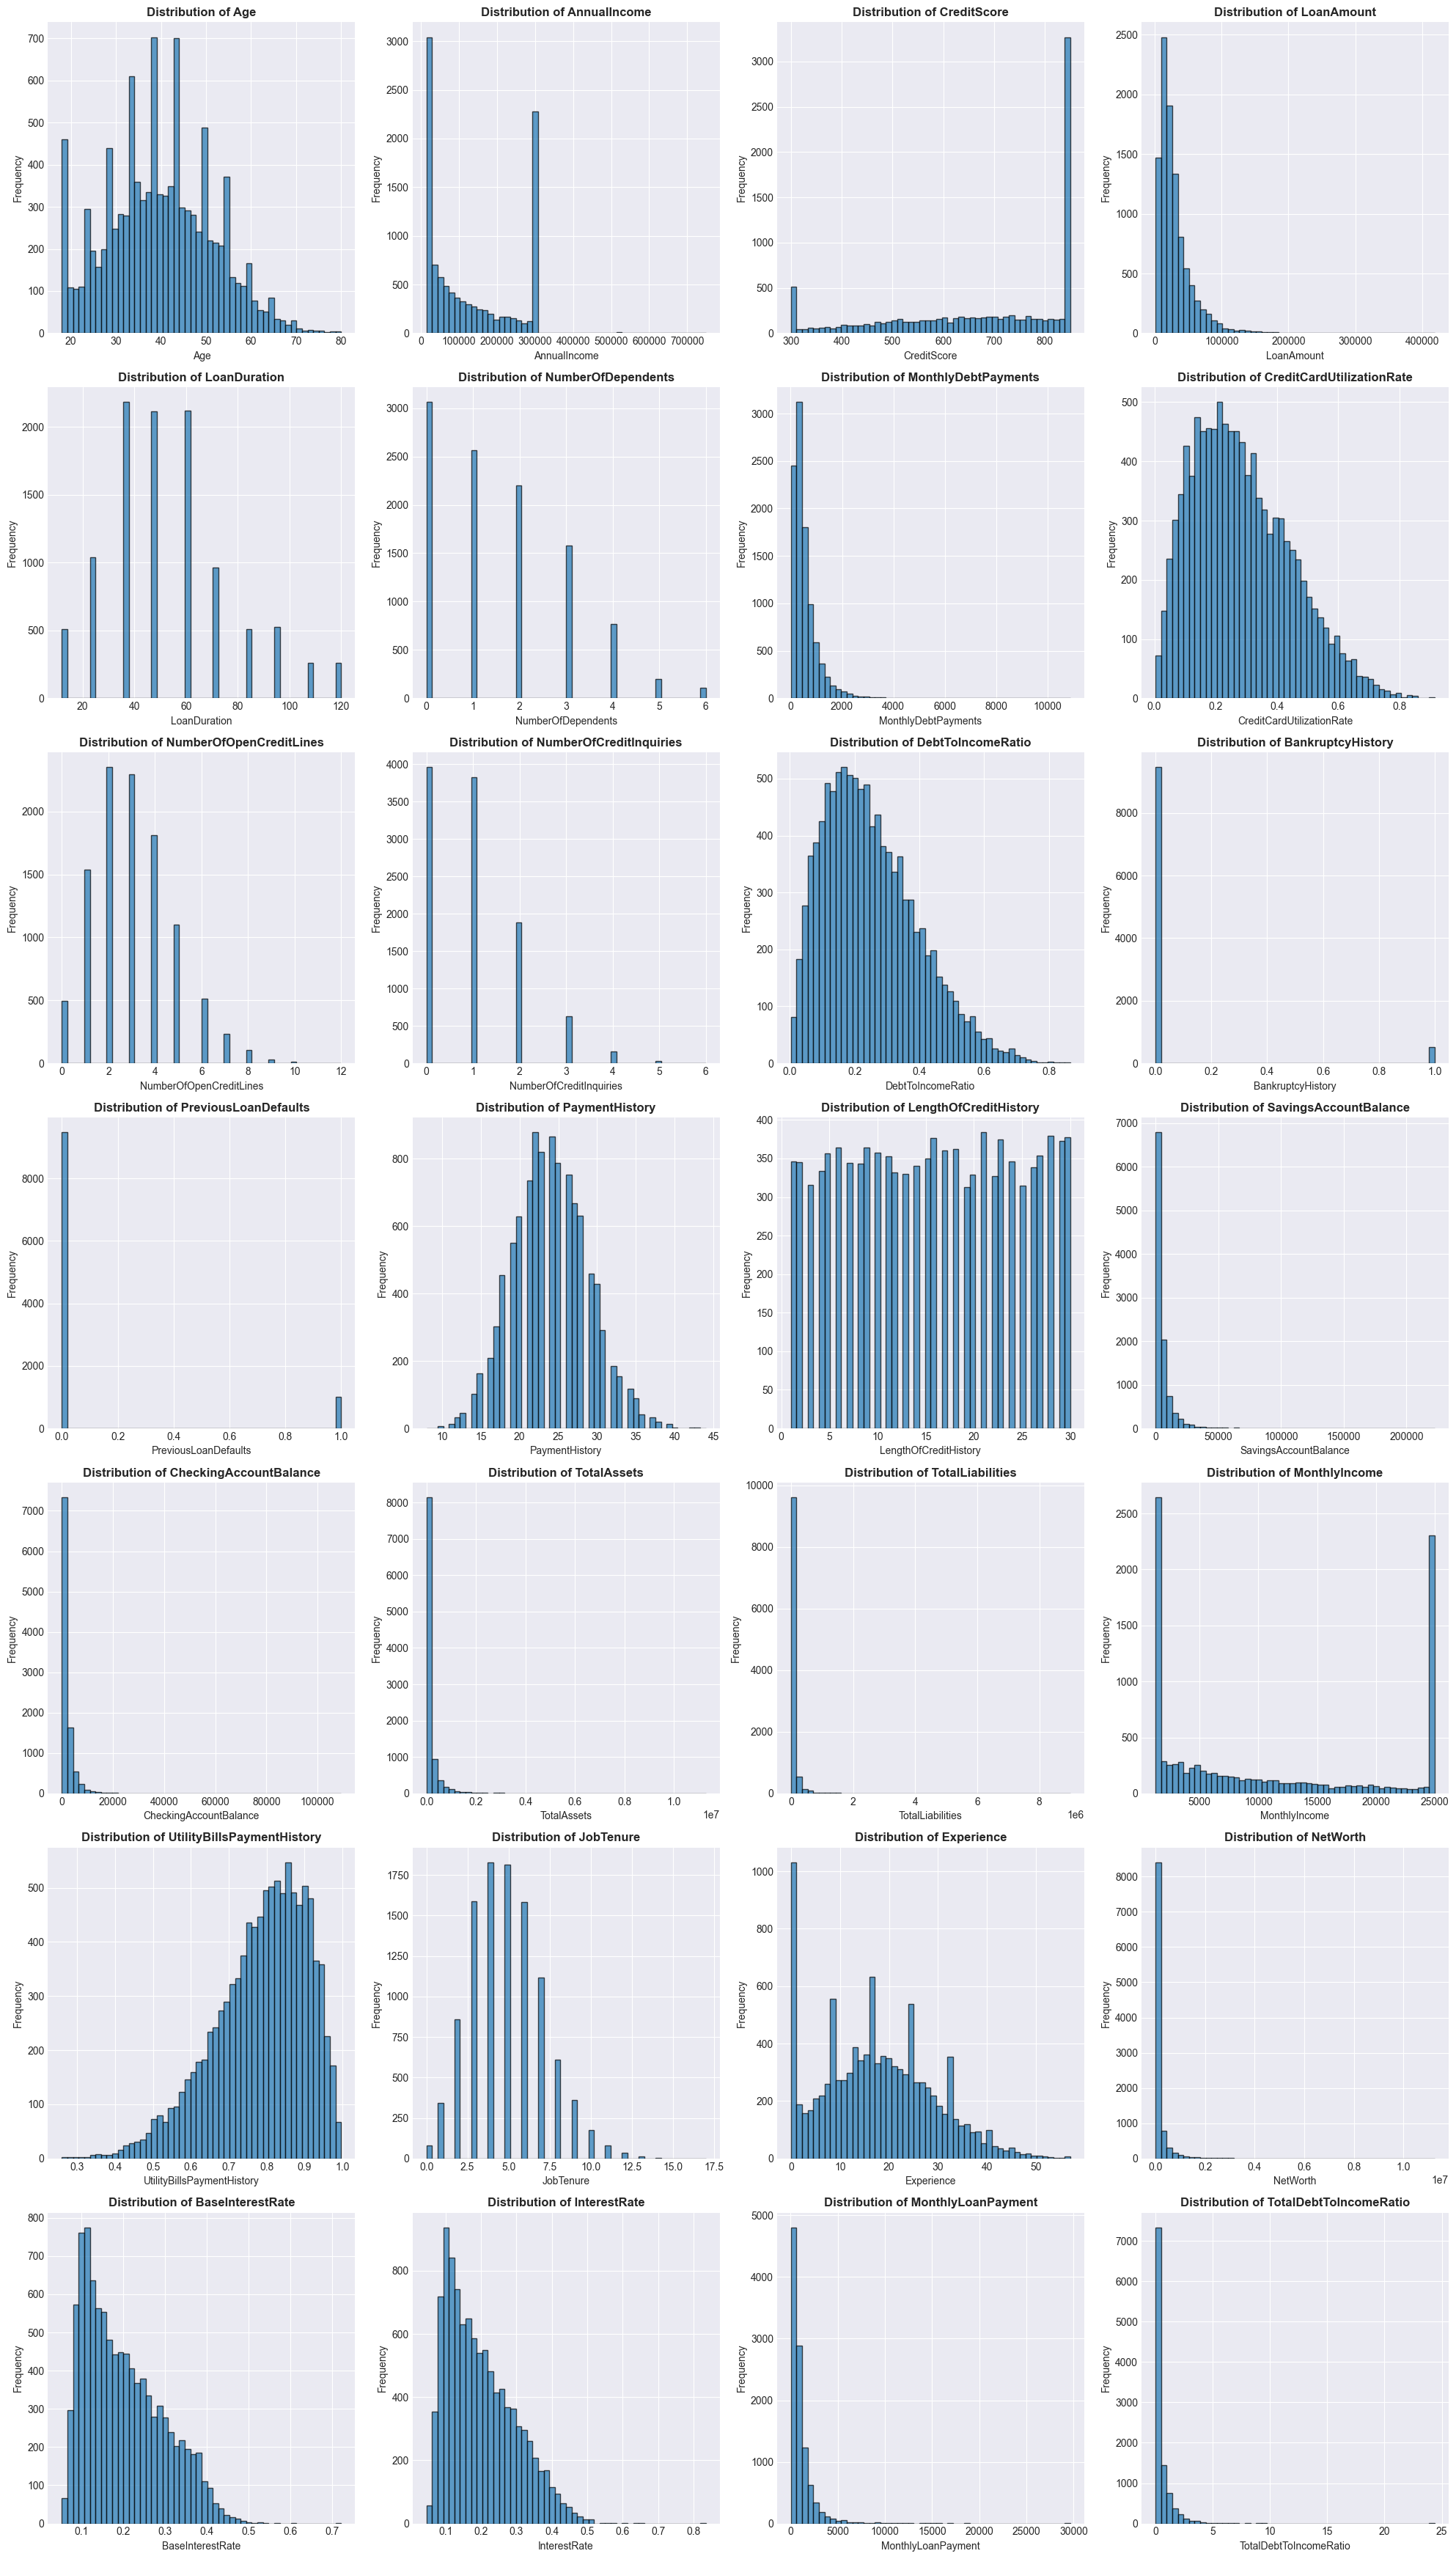

In [76]:
if len(numeric_cols) > 0:
    n_cols = 4
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            train_df[col].hist(bins=50, ax=axes[idx], edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Frequency')
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

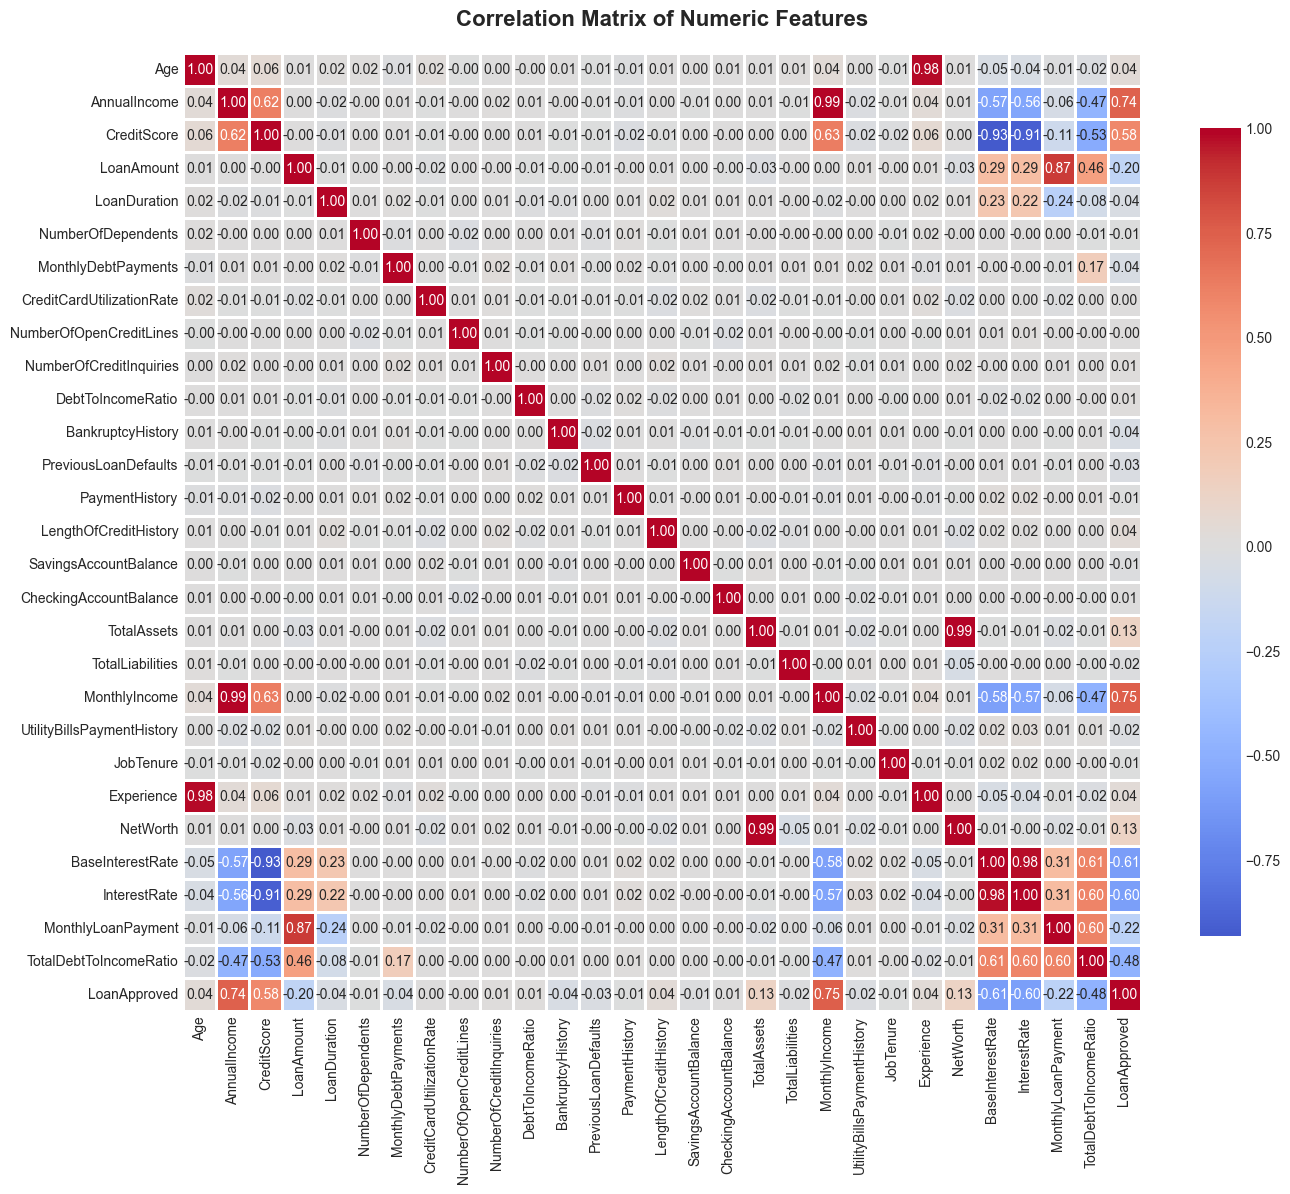


Features most correlated with LoanApproved:
MonthlyIncome                 0.754853
AnnualIncome                  0.743034
BaseInterestRate              0.605164
InterestRate                  0.599180
CreditScore                   0.581812
TotalDebtToIncomeRatio        0.476222
MonthlyLoanPayment            0.217369
LoanAmount                    0.195607
NetWorth                      0.129624
TotalAssets                   0.129204
MonthlyDebtPayments           0.044257
BankruptcyHistory             0.042160
LoanDuration                  0.039908
LengthOfCreditHistory         0.038509
Experience                    0.036699
Age                           0.036580
PreviousLoanDefaults          0.029994
UtilityBillsPaymentHistory    0.020812
TotalLiabilities              0.015154
DebtToIncomeRatio             0.014922
NumberOfCreditInquiries       0.012520
SavingsAccountBalance         0.011804
PaymentHistory                0.010064
CheckingAccountBalance        0.009503
JobTenure          

In [77]:
if len(numeric_cols) > 0:
    corr_cols = numeric_cols + ['LoanApproved']
    correlation_matrix = train_df[corr_cols].corr()
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numeric Features', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    print("\nFeatures most correlated with LoanApproved:")
    target_corr = correlation_matrix['LoanApproved'].abs().sort_values(ascending=False)
    print(target_corr[target_corr.index != 'LoanApproved'])

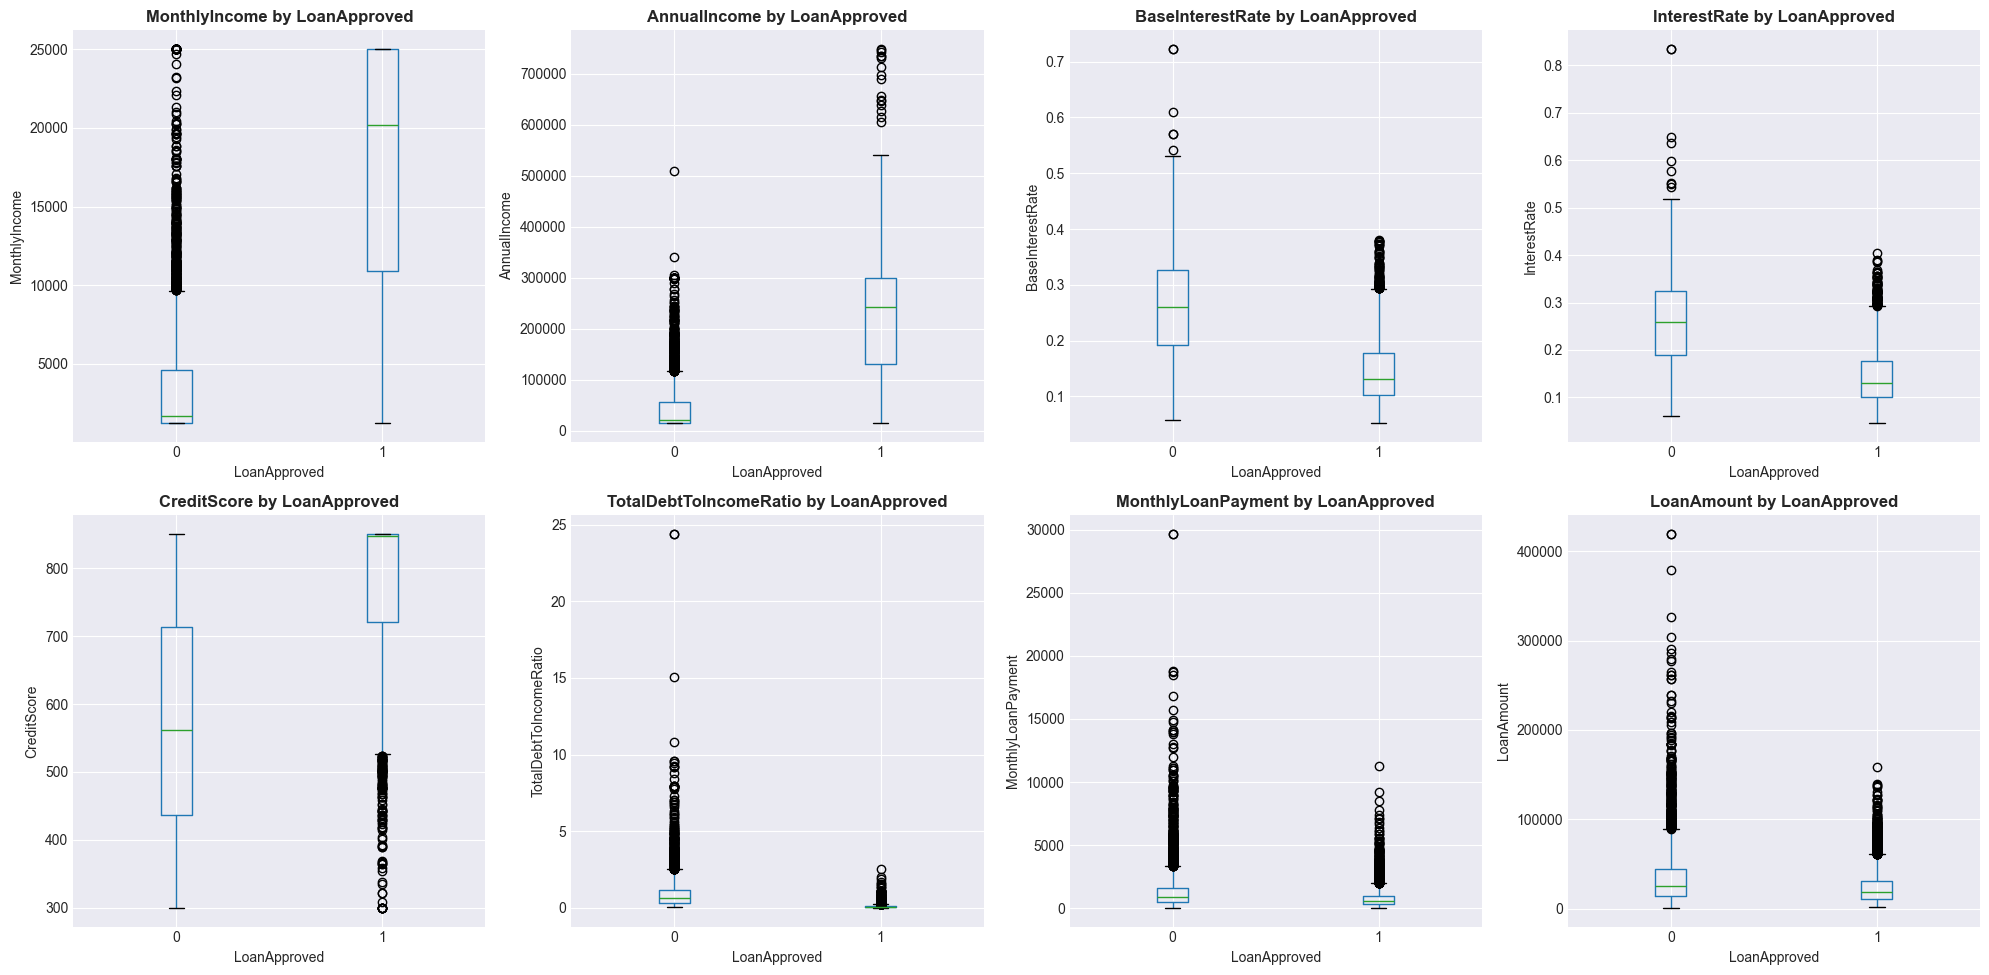

In [78]:
if len(numeric_cols) > 0:
    top_features = target_corr[target_corr.index != 'LoanApproved'].head(min(8, len(numeric_cols))).index.tolist()
    
    n_cols = 4
    n_rows = (len(top_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(top_features):
        if idx < len(axes):
            train_df.boxplot(column=col, by='LoanApproved', ax=axes[idx])
            axes[idx].set_title(f'{col} by LoanApproved', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('LoanApproved')
            axes[idx].set_ylabel(col)
            plt.sca(axes[idx])
            plt.xticks([1, 2], ['0', '1'])
    
    for idx in range(len(top_features), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()

In [79]:
if len(categorical_cols) > 0:
    for col in categorical_cols:
        print(train_df[col].value_counts())
        
        # Cross-tabulation with target
        print(f"\nCross-tabulation with LoanApproved:")
        ct = pd.crosstab(train_df[col], train_df['LoanApproved'], normalize='index')
        print(ct)

ApplicationDate
1996-04-03    3
1997-08-06    3
1983-01-31    3
1986-05-04    3
1995-04-25    3
             ..
1998-06-15    1
2000-06-26    1
1983-08-19    1
2019-09-25    1
2001-12-28    1
Name: count, Length: 10000, dtype: int64

Cross-tabulation with LoanApproved:
LoanApproved     0.0  1.0
ApplicationDate          
1979-01-01       1.0  0.0
1979-01-04       0.0  1.0
1979-01-09       0.0  1.0
1979-01-11       1.0  0.0
1979-01-13       1.0  0.0
...              ...  ...
2020-01-20       0.0  1.0
2020-01-21       0.0  1.0
2020-01-22       1.0  0.0
2020-01-24       1.0  0.0
2020-01-25       1.0  0.0

[10000 rows x 2 columns]
MaritalStatus
Married     5145
Single      3217
Divorced    1562
Widowed      563
Name: count, dtype: int64

Cross-tabulation with LoanApproved:
LoanApproved        0.0       1.0
MaritalStatus                    
Divorced       0.462228  0.537772
Married        0.493294  0.506706
Single         0.494249  0.505751
Widowed        0.479574  0.520426
HomeOwnershipStat

Подготовка данных

In [80]:
def preprocess_data(train, test, target_col='LoanApproved'):
    train = train.copy()
    test = test.copy()
    if target_col in train.columns:
        train = train.dropna(subset=[target_col]).reset_index(drop=True)
        y_train = train[target_col].values
        X_train = train.drop(columns=[target_col])
    else:
        y_train = None
        X_train = train.copy()
    
    X_test = test.copy()
    train_ids = X_train['ID'].values if 'ID' in X_train.columns else None
    test_ids = X_test['ID'].values if 'ID' in X_test.columns else None
    
    if 'ID' in X_train.columns:
        X_train = X_train.drop(columns=['ID'])
    if 'ID' in X_test.columns:
        X_test = X_test.drop(columns=['ID'])
    
    numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    
    X_train['_is_train'] = 1
    X_test['_is_train'] = 0
    combined = pd.concat([X_train, X_test], axis=0, ignore_index=True)
    
    for col in numeric_features:
        if col in combined.columns:
            combined[col] = combined[col].fillna(combined[col].median())
    
    for col in categorical_features:
        if col in combined.columns:
            combined[col] = combined[col].fillna(combined[col].mode().iloc[0] if len(combined[col].mode()) > 0 else 'Unknown')
    
    for col in categorical_features:
        if col in combined.columns:
            combined[col] = pd.Categorical(combined[col]).codes
    
    for col in numeric_features:
        if col in combined.columns:
            combined[col] = np.sign(combined[col]) * np.log1p(np.abs(combined[col]))
    
    X_train_processed = combined[combined['_is_train'] == 1].drop(columns=['_is_train']).reset_index(drop=True)
    X_test_processed = combined[combined['_is_train'] == 0].drop(columns=['_is_train']).reset_index(drop=True)
    
    return X_train_processed, X_test_processed, y_train, test_ids

X_train, X_test, y_train, test_ids = preprocess_data(train_df, test_df)

print(f"Processed train shape: {X_train.shape}")
print(f"Processed test shape: {X_test.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nTarget contains NaN: {pd.isna(y_train).any()}")
print(f"Target value counts:\n{pd.Series(y_train).value_counts()}")
print(f"\nFeature names: {X_train.columns.tolist()}")

Processed train shape: (10487, 34)
Processed test shape: (5000, 34)
Target shape: (10487,)

Target contains NaN: False
Target value counts:
1.0    5367
0.0    5120
Name: count, dtype: int64

Feature names: ['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'EmploymentStatus', 'EducationLevel', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio']


In [81]:
print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"\ny_train type: {type(y_train)}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train dtype: {y_train.dtype}")
print(f"\nПроверка NaN:")
print(f"Содержит NaN: {pd.isna(y_train).any()}")
print(f"Количество NaN: {pd.isna(y_train).sum()}")
print(f"Количество валидных: {(~pd.isna(y_train)).sum()}")
print(f"\nУникальные значения в y_train:")
print(pd.Series(y_train).value_counts(dropna=False))
print(f"\nПервые 20 значений y_train:")
print(y_train[:20])

if pd.isna(y_train).any():
    print("ПРОБЛЕМА: y_train содержит NaN!")
    print("Функция preprocess_data НЕ СРАБОТАЛА правильно!")
    print("Нужно проверить, что вы запустили ячейку с preprocess_data")
else:
    print("y_train чистый, можно продолжать")

X_train type: <class 'pandas.core.frame.DataFrame'>
X_train shape: (10487, 34)

y_train type: <class 'numpy.ndarray'>
y_train shape: (10487,)
y_train dtype: float64

Проверка NaN:
Содержит NaN: False
Количество NaN: 0
Количество валидных: 10487

Уникальные значения в y_train:
1.0    5367
0.0    5120
Name: count, dtype: int64

Первые 20 значений y_train:
[0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
y_train чистый, можно продолжать


In [82]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Train split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val.shape}")
print(f"\nTrain target distribution:")
print(pd.Series(y_train_split).value_counts(normalize=True))
print(f"\nValidation target distribution:")
print(pd.Series(y_val).value_counts(normalize=True))

Train split shape: (8389, 34)
Validation split shape: (2098, 34)

Train target distribution:
1.0    0.511742
0.0    0.488258
Name: proportion, dtype: float64

Validation target distribution:
1.0    0.511916
0.0    0.488084
Name: proportion, dtype: float64


## 2. Реализация метрик - 2 балла (0.5p каждая)

Реализуем основные метрики классификации с нуля и сравним с sklearn

In [83]:
def custom_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    
    return correct / total if total > 0 else 0.0


def custom_precision(y_true: np.ndarray, y_pred: np.ndarray, average='binary') -> float:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if average == 'binary':
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0
    
    elif average == 'macro':
        classes = np.unique(np.concatenate([y_true, y_pred]))
        precisions = []
        
        for cls in classes:
            tp = np.sum((y_true == cls) & (y_pred == cls))
            fp = np.sum((y_true != cls) & (y_pred == cls))
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            precisions.append(precision)
        
        return np.mean(precisions)


def custom_recall(y_true: np.ndarray, y_pred: np.ndarray, average='binary') -> float:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if average == 'binary':
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    elif average == 'macro':
        classes = np.unique(np.concatenate([y_true, y_pred]))
        recalls = []
        
        for cls in classes:
            tp = np.sum((y_true == cls) & (y_pred == cls))
            fn = np.sum((y_true == cls) & (y_pred != cls))
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            recalls.append(recall)
        
        return np.mean(recalls)


def custom_f1_score(y_true: np.ndarray, y_pred: np.ndarray, average='binary') -> float:
    precision = custom_precision(y_true, y_pred, average=average)
    recall = custom_recall(y_true, y_pred, average=average)
    
    if precision + recall == 0:
        return 0.0
    
    return 2 * (precision * recall) / (precision + recall)

In [84]:
y_true_test = np.array([0, 1, 1, 0, 1, 1, 0, 0, 1, 0])
y_pred_test = np.array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0])

custom_acc = custom_accuracy(y_true_test, y_pred_test)
sklearn_acc = accuracy_score(y_true_test, y_pred_test)
print(f"Accuracy:")
print(f"Custom:{custom_acc:.6f}")
print(f"Sklearn:{sklearn_acc:.6f}")
print(f"Match:{np.isclose(custom_acc, sklearn_acc)}")

custom_prec = custom_precision(y_true_test, y_pred_test)
sklearn_prec = precision_score(y_true_test, y_pred_test)
print(f"\nPrecision:")
print(f"Custom:{custom_prec:.6f}")
print(f"Sklearn:{sklearn_prec:.6f}")
print(f"Match:{np.isclose(custom_prec, sklearn_prec)}")

custom_rec = custom_recall(y_true_test, y_pred_test)
sklearn_rec = recall_score(y_true_test, y_pred_test)
print(f"\nRecall:")
print(f"Custom:{custom_rec:.6f}")
print(f"Sklearn:{sklearn_rec:.6f}")
print(f"Match:{np.isclose(custom_rec, sklearn_rec)}")

custom_f1 = custom_f1_score(y_true_test, y_pred_test)
sklearn_f1 = f1_score(y_true_test, y_pred_test)
print(f"\nF1-score:")
print(f"Custom:{custom_f1:.6f}")
print(f"Sklearn:{sklearn_f1:.6f}")
print(f"Match:{np.isclose(custom_f1, sklearn_f1)}")

Accuracy:
Custom:0.800000
Sklearn:0.800000
Match:True

Precision:
Custom:0.800000
Sklearn:0.800000
Match:True

Recall:
Custom:0.800000
Sklearn:0.800000
Match:True

F1-score:
Custom:0.800000
Sklearn:0.800000
Match:True


## 3. Реализация Bagging - 3 балла

Создадим собственный класс Bagging с методом fit и сравним результаты с sklearn

In [85]:
class CustomBaggingClassifier:
    def __init__(self, base_estimator=None, n_estimators=10, 
                 max_samples=1.0, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.estimators_ = []
        
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        
        X = np.array(X)
        y = np.array(y)
        
        n_samples = X.shape[0]
        n_samples_subset = int(n_samples * self.max_samples)
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples_subset, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            
            if self.base_estimator is None:
                estimator = DecisionTreeClassifier(random_state=self.random_state)
            else:
                from sklearn.base import clone
                estimator = clone(self.base_estimator)
            
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)
        
        return self
    
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        X = np.array(X)
        
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
    
        from scipy import stats
        final_predictions = stats.mode(predictions, axis=0, keepdims=False)[0]
        
        return final_predictions
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        X = np.array(X)
        
        probas = np.array([estimator.predict_proba(X) for estimator in self.estimators_])
        avg_probas = np.mean(probas, axis=0)
        
        return avg_probas

In [86]:
custom_bagging = CustomBaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    n_estimators=50,
    max_samples=0.8,
    random_state=RANDOM_STATE
)

custom_bagging.fit(X_train_split, y_train_split)
y_pred_custom = custom_bagging.predict(X_val)
y_proba_custom = custom_bagging.predict_proba(X_val)[:, 1]

sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    n_estimators=50,
    max_samples=0.8,
    random_state=RANDOM_STATE
)

sklearn_bagging.fit(X_train_split, y_train_split)
y_pred_sklearn = sklearn_bagging.predict(X_val)
y_proba_sklearn = sklearn_bagging.predict_proba(X_val)[:, 1]

print(f"\n{'Metric':<20} {'Custom Bagging':<20} {'sklearn Bagging':<20}")

metrics = [
    ('Accuracy', custom_accuracy(y_val, y_pred_custom), accuracy_score(y_val, y_pred_sklearn)),
    ('Precision', custom_precision(y_val, y_pred_custom), precision_score(y_val, y_pred_sklearn)),
    ('Recall', custom_recall(y_val, y_pred_custom), recall_score(y_val, y_pred_sklearn)),
    ('F1-score', custom_f1_score(y_val, y_pred_custom), f1_score(y_val, y_pred_sklearn)),
    ('ROC-AUC', roc_auc_score(y_val, y_proba_custom), roc_auc_score(y_val, y_proba_sklearn))
]

for metric_name, custom_val, sklearn_val in metrics:
    print(f"{metric_name:<20} {custom_val:<20.6f} {sklearn_val:<20.6f}")


Metric               Custom Bagging       sklearn Bagging     
Accuracy             0.912297             0.916587            
Precision            0.911275             0.910502            
Recall               0.918063             0.928305            
F1-score             0.914657             0.919318            
ROC-AUC              0.975467             0.974676            


## 4. Реализация Gradient Boosting - 5 баллов

Создадим собственный класс Gradient Boosting и сравним с sklearn

In [87]:
class CustomGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 min_samples_split=2, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.estimators_ = []
        self.init_prediction_ = None
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def _log_odds(self, y):
        p = np.mean(y)
        p = np.clip(p, 1e-7, 1 - 1e-7)
        return np.log(p / (1 - p))
    
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        
        X = np.array(X)
        y = np.array(y)
        
        n_samples = X.shape[0]
        
        self.init_prediction_ = self._log_odds(y)
        
        F = np.full(n_samples, self.init_prediction_)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            probas = self._sigmoid(F)
        
            residuals = y - probas
            
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state if self.random_state is None else self.random_state + i
            )
            from sklearn.tree import DecisionTreeRegressor
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state if self.random_state is None else self.random_state + i
            )
            
            tree.fit(X, residuals)
            update = tree.predict(X)
            F += self.learning_rate * update
            
            self.estimators_.append(tree)
        
        return self
    
    def _predict_raw(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        X = np.array(X)
        n_samples = X.shape[0]
        F = np.full(n_samples, self.init_prediction_)
        for tree in self.estimators_:
            F += self.learning_rate * tree.predict(X)
        
        return F
    
    def predict_proba(self, X):
        raw_predictions = self._predict_raw(X)
        probas_class_1 = self._sigmoid(raw_predictions)
        probas_class_0 = 1 - probas_class_1
        
        return np.column_stack([probas_class_0, probas_class_1])
    
    def predict(self, X):
        probas = self.predict_proba(X)[:, 1]
        return (probas >= 0.5).astype(int)


In [88]:
custom_gb = CustomGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE
)

custom_gb.fit(X_train_split, y_train_split)
y_pred_custom_gb = custom_gb.predict(X_val)
y_proba_custom_gb = custom_gb.predict_proba(X_val)[:, 1]

sklearn_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE
)

sklearn_gb.fit(X_train_split, y_train_split)
y_pred_sklearn_gb = sklearn_gb.predict(X_val)
y_proba_sklearn_gb = sklearn_gb.predict_proba(X_val)[:, 1]

print(f"\n{'Metric':<20} {'Custom GB':<20} {'sklearn GB':<20}")
metrics_gb = [
    ('Accuracy', custom_accuracy(y_val, y_pred_custom_gb), accuracy_score(y_val, y_pred_sklearn_gb)),
    ('Precision', custom_precision(y_val, y_pred_custom_gb), precision_score(y_val, y_pred_sklearn_gb)),
    ('Recall', custom_recall(y_val, y_pred_custom_gb), recall_score(y_val, y_pred_sklearn_gb)),
    ('F1-score', custom_f1_score(y_val, y_pred_custom_gb), f1_score(y_val, y_pred_sklearn_gb)),
    ('ROC-AUC', roc_auc_score(y_val, y_proba_custom_gb), roc_auc_score(y_val, y_proba_sklearn_gb))
]

for metric_name, custom_val, sklearn_val in metrics_gb:
    print(f"{metric_name:<20} {custom_val:<20.6f} {sklearn_val:<20.6f}")



Metric               Custom GB            sklearn GB          
Accuracy             0.917064             0.924214            
Precision            0.916667             0.924004            
Recall               0.921788             0.928305            
F1-score             0.919220             0.926150            
ROC-AUC              0.975097             0.980458            


## 5. Сравнение алгоритмов Gradient Boosting - 1 балл

Сравним sklearn, LightGBM, XGBoost и CatBoost

In [89]:
results = {}
results['sklearn'] = {
    'model': sklearn_gb,
    'predictions': y_pred_sklearn_gb,
    'probabilities': y_proba_sklearn_gb
}

if LIGHTGBM_AVAILABLE:
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE,
        verbosity=-1
    )
    lgb_model.fit(X_train_split, y_train_split)
    results['LightGBM'] = {
        'model': lgb_model,
        'predictions': lgb_model.predict(X_val),
        'probabilities': lgb_model.predict_proba(X_val)[:, 1]
    }
else:
    print("LightGBM skipped")

if XGBOOST_AVAILABLE:
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train_split, y_train_split, verbose=False)
    results['XGBoost'] = {
        'model': xgb_model,
        'predictions': xgb_model.predict(X_val),
        'probabilities': xgb_model.predict_proba(X_val)[:, 1]
    }
else:
    print("XGBoost skipped")

if CATBOOST_AVAILABLE:
    cat_model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=3,
        random_state=RANDOM_STATE,
        verbose=False
    )
    cat_model.fit(X_train_split, y_train_split, verbose=False)
    results['CatBoost'] = {
        'model': cat_model,
        'predictions': cat_model.predict(X_val).flatten(),
        'probabilities': cat_model.predict_proba(X_val)[:, 1]
    }
else:
    print("CatBoost skipped")

print(f"\n✓ {len(results)} models trained successfully!")


✓ 4 models trained successfully!


In [90]:
comparison_df = pd.DataFrame()

for name, result in results.items():
    y_pred = result['predictions']
    y_proba = result['probabilities']
    
    comparison_df[name] = [
        accuracy_score(y_val, y_pred),
        precision_score(y_val, y_pred),
        recall_score(y_val, y_pred),
        f1_score(y_val, y_pred),
        roc_auc_score(y_val, y_proba)
    ]

comparison_df.index = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']

print("\n", comparison_df.round(6))

best_model_name = comparison_df.loc['ROC-AUC'].idxmax()
best_roc_auc = comparison_df.loc['ROC-AUC'].max()

best_model = results[best_model_name]['model']


             sklearn  LightGBM   XGBoost  CatBoost
Accuracy   0.924214  0.923260  0.924214  0.925643
Precision  0.924004  0.922294  0.922438  0.921101
Recall     0.928305  0.928305  0.930168  0.934823
F1-score   0.926150  0.925290  0.926287  0.927911
ROC-AUC    0.980458  0.980279  0.980572  0.980063


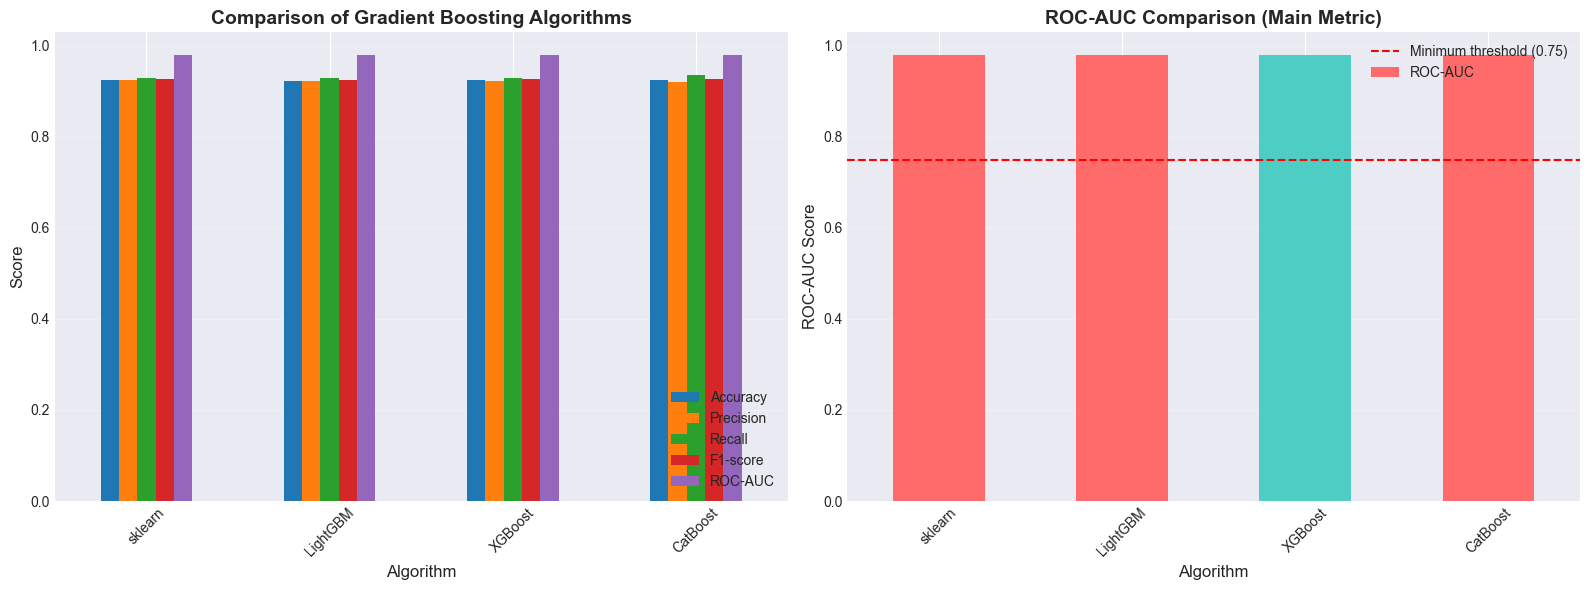

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

comparison_df.T.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Comparison of Gradient Boosting Algorithms', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Algorithm', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

roc_auc_scores = comparison_df.loc['ROC-AUC']
colors = ['#FF6B6B' if x != best_model_name else '#4ECDC4' for x in roc_auc_scores.index]
roc_auc_scores.plot(kind='bar', ax=axes[1], color=colors, rot=45)
axes[1].set_title('ROC-AUC Comparison (Main Metric)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Algorithm', fontsize=12)
axes[1].set_ylabel('ROC-AUC Score', fontsize=12)
axes[1].axhline(y=0.75, color='red', linestyle='--', label='Minimum threshold (0.75)')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Оптимизация гиперпараметров с Optuna - 2 балла

Используем Optuna для подбора оптимальных гиперпараметров лучшей модели

In [92]:
if not OPTUNA_AVAILABLE:
    print("⚠️ Optuna is not available. Skipping hyperparameter optimization.")
    print("Using best model from previous comparison without optimization.")
    study = None
    best_params_dict = {
        'sklearn': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': RANDOM_STATE},
        'LightGBM': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': RANDOM_STATE, 'verbosity': -1},
        'XGBoost': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': RANDOM_STATE, 'eval_metric': 'logloss'},
        'CatBoost': {'iterations': 100, 'learning_rate': 0.1, 'depth': 3, 'random_state': RANDOM_STATE, 'verbose': False}
    }
    
    class DummyStudy:
        def __init__(self):
            self.best_params = best_params_dict.get(best_model_name, {})
            self.best_value = comparison_df.loc['ROC-AUC', best_model_name]
    
    study = DummyStudy()
else:

    def objective(trial):
        if best_model_name == 'LightGBM' and LIGHTGBM_AVAILABLE:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'random_state': RANDOM_STATE,
                'verbosity': -1
            }
            model = lgb.LGBMClassifier(**params)
            
        elif best_model_name == 'XGBoost' and XGBOOST_AVAILABLE:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'random_state': RANDOM_STATE,
                'eval_metric': 'logloss'
            }
            model = xgb.XGBClassifier(**params)
            
        elif best_model_name == 'CatBoost' and CATBOOST_AVAILABLE:
            params = {
                'iterations': trial.suggest_int('iterations', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'depth': trial.suggest_int('depth', 3, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
                'border_count': trial.suggest_int('border_count', 32, 255),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_state': RANDOM_STATE,
                'verbose': False
            }
            model = CatBoostClassifier(**params)
            
        else:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'random_state': RANDOM_STATE
            }
            model = GradientBoostingClassifier(**params)
        model.fit(X_train_split, y_train_split)
        y_proba = model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_proba)
        
        return roc_auc
    study = optuna.create_study(direction='maximize', study_name=f'{best_model_name}_optimization')

    print(f"\nStarting optimization with 50 trials...")
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print(f"Best ROC-AUC: {study.best_value:.6f}")
    print(f"\nBest hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

[I 2025-12-10 23:58:02,830] A new study created in memory with name: XGBoost_optimization



Starting optimization with 50 trials...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-10 23:58:03,044] Trial 0 finished with value: 0.9806851577048418 and parameters: {'n_estimators': 90, 'learning_rate': 0.26467048161042694, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8652328546413368, 'colsample_bytree': 0.7249797945991774, 'gamma': 5.935684306717178e-06, 'reg_alpha': 9.707320528027866, 'reg_lambda': 3.3331213294559144e-07}. Best is trial 0 with value: 0.9806851577048418.
[I 2025-12-10 23:58:03,593] Trial 1 finished with value: 0.9783755964851024 and parameters: {'n_estimators': 201, 'learning_rate': 0.01064750821684344, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.9794728041127327, 'colsample_bytree': 0.8456368561014415, 'gamma': 0.1337802638387466, 'reg_alpha': 0.016994247249197833, 'reg_lambda': 1.525300704395086}. Best is trial 0 with value: 0.9806851577048418.
[I 2025-12-10 23:58:03,799] Trial 2 finished with value: 0.9774585915677374 and parameters: {'n_estimators': 101, 'learning_rate': 0.017583699177247527, 'max_depth': 6, 'min_ch

In [93]:
try:
    fig = plot_optimization_history(study)
    fig.update_layout(title=f'{best_model_name} Optimization History', width=900, height=500)
    fig.show()
except:
    plt.figure(figsize=(12, 6))
    trials = study.trials
    values = [trial.value for trial in trials]
    plt.plot(values, marker='o', linestyle='-', alpha=0.6)
    plt.axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.6f}')
    plt.xlabel('Trial', fontsize=12)
    plt.ylabel('ROC-AUC', fontsize=12)
    plt.title(f'{best_model_name} Optimization History', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [94]:
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{best_model_name} Parameter Importances', width=900, height=600)
    fig.show()
except:
    print("Parameter importance visualization not available")

In [95]:
if best_model_name == 'LightGBM':
    final_model = lgb.LGBMClassifier(**study.best_params, random_state=RANDOM_STATE, verbosity=-1)
elif best_model_name == 'XGBoost':
    final_model = xgb.XGBClassifier(**study.best_params, random_state=RANDOM_STATE, eval_metric='logloss')
elif best_model_name == 'CatBoost':
    final_model = CatBoostClassifier(**study.best_params, random_state=RANDOM_STATE, verbose=False)
else:
    final_model = GradientBoostingClassifier(**study.best_params, random_state=RANDOM_STATE)

final_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6355736238985465
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## 7. Оценка финальной модели

Оценим производительность финальной оптимизированной модели

In [96]:
X_train_eval, X_val_eval, y_train_eval, y_val_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)
eval_model = final_model.__class__(**study.best_params)
if best_model_name == 'LightGBM':
    eval_model = lgb.LGBMClassifier(**study.best_params, random_state=RANDOM_STATE, verbosity=-1)
elif best_model_name == 'XGBoost':
    eval_model = xgb.XGBClassifier(**study.best_params, random_state=RANDOM_STATE, eval_metric='logloss')
elif best_model_name == 'CatBoost':
    eval_model = CatBoostClassifier(**study.best_params, random_state=RANDOM_STATE, verbose=False)
else:
    eval_model = GradientBoostingClassifier(**study.best_params, random_state=RANDOM_STATE)

eval_model.fit(X_train_eval, y_train_eval)
y_pred_final = eval_model.predict(X_val_eval)
y_proba_final = eval_model.predict_proba(X_val_eval)[:, 1]

print(f"Model: {best_model_name} (Optimized)\n")

print(f"{'Metric':<20} {'Custom':<20} {'sklearn':<20}")

acc_custom = custom_accuracy(y_val_eval, y_pred_final)
acc_sklearn = accuracy_score(y_val_eval, y_pred_final)
print(f"{'Accuracy':<20} {acc_custom:<20.6f} {acc_sklearn:<20.6f}")

prec_custom = custom_precision(y_val_eval, y_pred_final)
prec_sklearn = precision_score(y_val_eval, y_pred_final)
print(f"{'Precision':<20} {prec_custom:<20.6f} {prec_sklearn:<20.6f}")

rec_custom = custom_recall(y_val_eval, y_pred_final)
rec_sklearn = recall_score(y_val_eval, y_pred_final)
print(f"{'Recall':<20} {rec_custom:<20.6f} {rec_sklearn:<20.6f}")

f1_custom = custom_f1_score(y_val_eval, y_pred_final)
f1_sklearn = f1_score(y_val_eval, y_pred_final)
print(f"{'F1-score':<20} {f1_custom:<20.6f} {f1_sklearn:<20.6f}")

roc_auc = roc_auc_score(y_val_eval, y_proba_final)
print(f"{'ROC-AUC':<20} {roc_auc:<20.6f} {'(Main Metric)':<20}")

if roc_auc >= 0.75:
    print(f"ROC-AUC >= 0.75: Model meets the minimum requirement!")
else:
    print(f"ROC-AUC < 0.75: Model needs improvement")

Model: XGBoost (Optimized)

Metric               Custom               sklearn             
Accuracy             0.928503             0.928503            
Precision            0.925414             0.925414            
Recall               0.935754             0.935754            
F1-score             0.930556             0.930556            
ROC-AUC              0.983176             (Main Metric)       
ROC-AUC >= 0.75: Model meets the minimum requirement!


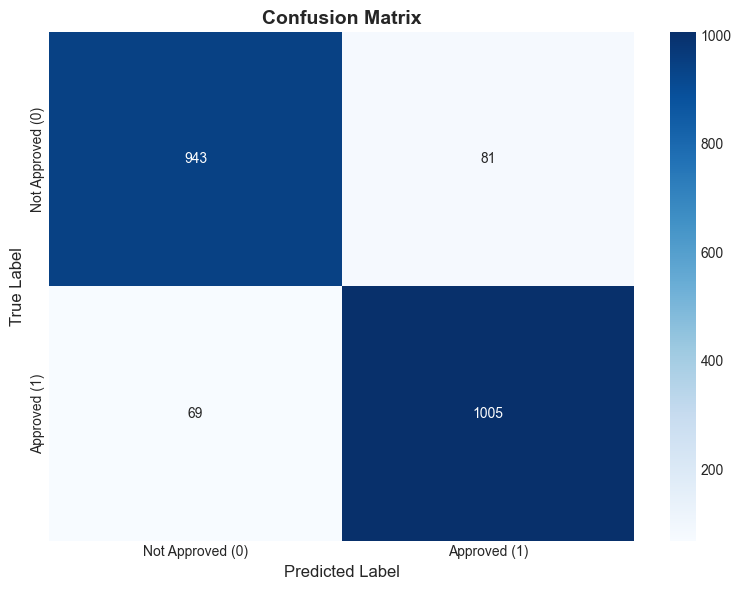

              precision    recall  f1-score   support

Not Approved       0.93      0.92      0.93      1024
    Approved       0.93      0.94      0.93      1074

    accuracy                           0.93      2098
   macro avg       0.93      0.93      0.93      2098
weighted avg       0.93      0.93      0.93      2098



In [97]:
cm = confusion_matrix(y_val_eval, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()
print(classification_report(y_val_eval, y_pred_final, target_names=['Not Approved', 'Approved']))

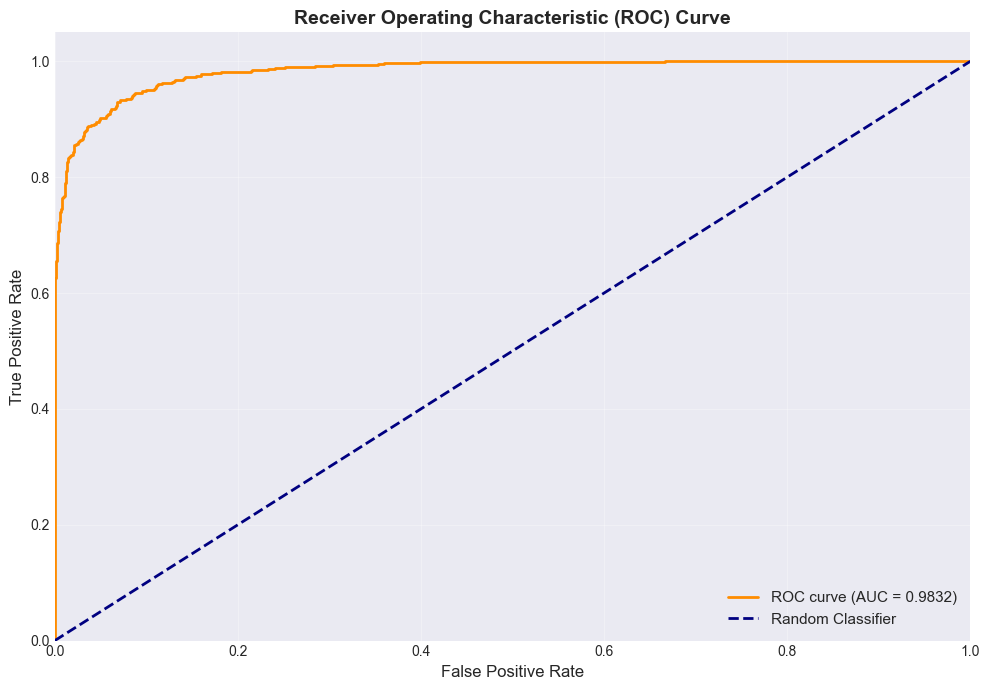

In [98]:
fpr, tpr, thresholds = roc_curve(y_val_eval, y_proba_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

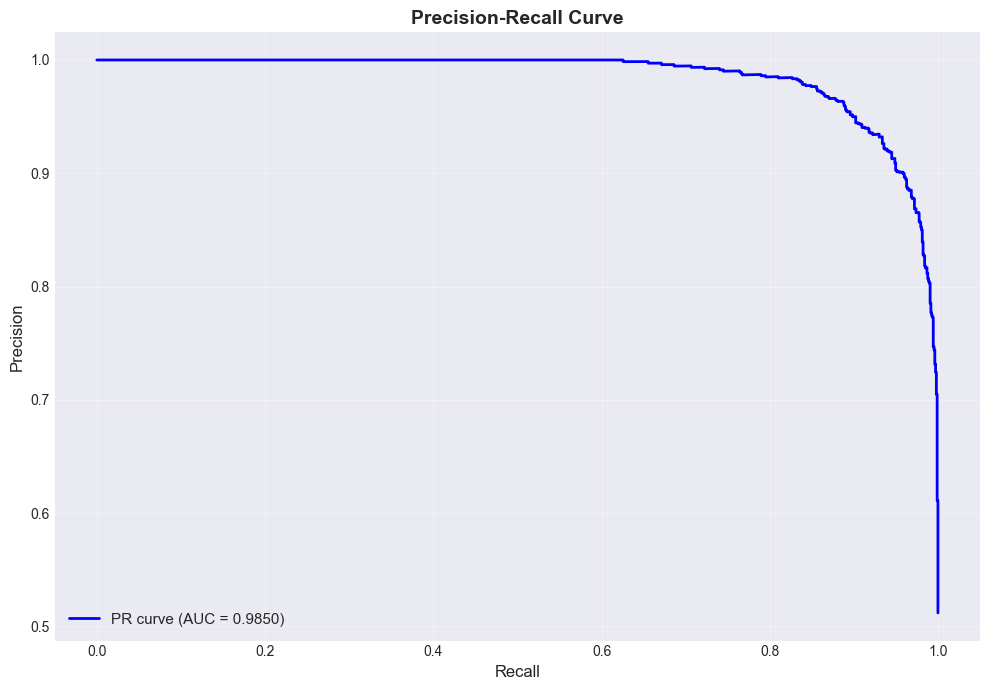

In [99]:
precision_curve, recall_curve, _ = precision_recall_curve(y_val_eval, y_proba_final)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(10, 7))
plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Предсказания для тестовой выборки

Сделаем предсказания для Kaggle submission

In [100]:
test_predictions = final_model.predict_proba(X_test)[:, 1]

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test predictions range: [{test_predictions.min():.4f}, {test_predictions.max():.4f}]")
print(f"\nFirst 10 predictions: {test_predictions[:10]}")

Test predictions shape: (5000,)
Test predictions range: [0.0000, 1.0000]

First 10 predictions: [9.997671e-01 9.418296e-04 9.999186e-01 9.996902e-01 9.995524e-01
 4.491307e-04 9.999603e-01 9.991366e-01 9.096235e-01 4.065575e-05]


In [101]:
submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_predictions
})

submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")

   ID  LoanApproved
0   0      0.999767
1   1      0.000942
2   2      0.999919
3   3      0.999690
4   4      0.999552
5   5      0.000449
6   6      0.999960
7   7      0.999137
8   8      0.909624
9   9      0.000041

Submission shape: (5000, 2)
